# Modelling Hallucinations

This notebook includes the results for part 2 of the "Toy Models of Superposition Review" assignment.

A lot of the code has been taken from Anthropic's [toy models framework](https://colab.research.google.com/github/anthropics/toy-models-of-superposition/blob/main/toy_models.ipynb) and [FIT5215's assignment 2](https://colab.research.google.com/drive/1m0mh9Mk4-AKEhgAHRwQdl5mc0x7SF7Tv?usp=sharing) and has been repurposed for our specific use case.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange, tqdm

import time
import pandas as pd
import os

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import nltk
import csv
from nltk.corpus import words

from sklearn import preprocessing
from transformers import BertTokenizer
import ast
import random
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_all(seed=42069):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all()

if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'
DEVICE = torch.device(DEVICE)

## Dataset

Using the `nltk` toolkit, we create our dataset using the following affixes:
- un-
- re-
- -able
- -ful
- -ness

In [3]:
# Download the words corpus if not already downloaded
nltk.download('words', quiet=True)

# Get the list of English words
english_words = words.words()

# Define prefixes and suffixes
prefixes = ['un', 're']
suffixes = ['able', 'ful', 'ness']

# Function to categorize a word
def categorize_word(word):
    prefix_match = next((prefix for prefix in prefixes if word.startswith(prefix)), None)
    suffix_match = next((suffix for suffix in suffixes if word.endswith(suffix)), None)
    
    if prefix_match and suffix_match:
        return [prefix_match, suffix_match]
    elif prefix_match:
        return prefix_match
    elif suffix_match:
        return suffix_match
    else:
        return None

# Process words and create dataset
dataset = []
for word in english_words:
    category = categorize_word(word)
    if category:
        dataset.append([word, category])

# Save to CSV
with open('word_affixes_dataset.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['word', 'category'])  # Header
    writer.writerows(dataset)

print(f"Dataset created with {len(dataset)} words.")

Dataset created with 28611 words.


## Defining classes

We define the following classes:
- `DataManager`: For loading the data and splitting it into the train, test and dual datasets
- `BaseTrainer`: The trainer for training and evaluating the model
- `Model`: The model we will use for training

In [4]:
class DataManager:
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_words = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.numeral_data = list()

    def read_csv_data(self, file_path):
        df = pd.read_csv(file_path)

        # Separate 'dual' class where category is more than one
        dual_data = df[df["category"].str.contains(",")]
        non_dual_data = df[~df["category"].str.contains(",")]

        self.str_words = non_dual_data["word"].tolist()
        self.str_labels = non_dual_data["category"].tolist()
        self.dual_words = dual_data["word"].tolist()
        self.dual_labels = dual_data["category"].tolist()

        # Process max sentence length
        for question in self.str_words + self.dual_words:
            if self.max_sentence_len < len(str(question)):
                self.max_sentence_len = len(str(question))

        # Encode labels (excluding 'dual')
        le = preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes = le.classes_
        self.num_classes = len(self.str_classes)

        # Encode dual labels
        dual_labels_temp = []
        for label in self.dual_labels:
            categories = ast.literal_eval(label)
            encoded_cats = le.transform(categories)
            dual_labels_temp.append(encoded_cats.tolist())
        self.dual_labels = dual_labels_temp

        if self.verbose:
            print("\nSample words and corresponding categories (non-dual)... \n")
            print(self.str_words[:5])
            print(self.str_labels[:5])
            print("\nSample dual words...\n")
            print(self.dual_words[:5])
            print(self.dual_labels[:5])

    def manipulate_data(self):
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        vocab = self.tokenizer.get_vocab()
        self.word2idx = {w: i for i, w in enumerate(vocab)}
        self.idx2word = {i: w for w, i in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)

        num_seqs = []
        dual_num_seqs = []

        # Process non-dual words
        for text in self.str_words:
            text_seqs = self.tokenizer.tokenize(str(text))
            token_ids = self.tokenizer.convert_tokens_to_ids(text_seqs)
            seq_tensor = torch.LongTensor(token_ids)
            num_seqs.append(seq_tensor)

        # Process dual words
        for text in self.dual_words:
            text_seqs = self.tokenizer.tokenize(str(text))
            token_ids = self.tokenizer.convert_tokens_to_ids(text_seqs)
            seq_tensor = torch.LongTensor(token_ids)
            dual_num_seqs.append(seq_tensor)

        if num_seqs:
            self.numeral_data = pad_sequence(num_seqs, batch_first=True)
            self.num_sentences, self.max_seq_len = self.numeral_data.shape

        if dual_num_seqs:
            self.dual_data = pad_sequence(dual_num_seqs, batch_first=True)
            self.num_dual_sentences, self.max_dual_seq_len = self.dual_data.shape

        # Ensure dual data has the same max sequence length as non-dual data
        if hasattr(self, "numeral_data") and hasattr(self, "dual_data"):
            max_len = max(self.max_seq_len, self.max_dual_seq_len)
            self.numeral_data = F.pad(
                self.numeral_data, (0, max_len - self.max_seq_len)
            )
            self.dual_data = F.pad(self.dual_data, (0, max_len - self.max_dual_seq_len))
            self.max_seq_len = max_len
            self.max_dual_seq_len = max_len

    def tokenize_data(self, text):
        text_seqs = self.tokenizer.tokenize(str(text))
        token_ids = self.tokenizer.convert_tokens_to_ids(text_seqs)
        seq_tensor = torch.LongTensor(token_ids)
        return seq_tensor

    def train_test_split(self, train_ratio=0.8):
        # Split non-dual data
        train_size = int(len(self.str_words) * train_ratio)

        indices = list(range(len(self.str_words)))
        random.shuffle(indices)

        train_indices = indices[:train_size]
        test_indices = indices[train_size:]

        # Create datasets
        train_data = [self.numeral_data[i] for i in train_indices]
        train_labels = [self.numeral_labels[i] for i in train_indices]
        test_data = [self.numeral_data[i] for i in test_indices]
        test_labels = [self.numeral_labels[i] for i in test_indices]
        dual_data = [self.dual_data[i] for i in range(len(self.dual_words))]
        dual_labels = [self.dual_labels[i] for i in range(len(self.dual_words))]

        # Create DataLoaders
        self.train_loader = DataLoader(
            TensorDataset(torch.stack(train_data), torch.tensor(train_labels)),
            batch_size=64,
            shuffle=True,
        )
        self.test_loader = DataLoader(
            TensorDataset(torch.stack(test_data), torch.tensor(test_labels)),
            batch_size=64,
            shuffle=False,
        )
        self.dual_loader = DataLoader(
            TensorDataset(torch.stack(dual_data), torch.tensor(dual_labels)),
            batch_size=64,
            shuffle=False,
        )

In [5]:
class BaseTrainer:
    def __init__(self, model, criterion, optimizer, train_loader, device):
        self.model = model.to(device)
        self.criterion = criterion  # the loss function
        self.optimizer = optimizer  # the optimizer
        self.train_loader = train_loader  # the train loader
        self.device = device

    # the function to train the model in many epochs
    def fit(self, num_epochs):
        self.num_batches = len(self.train_loader)

        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_loss, train_accuracy = self.train_one_epoch()
            print(
                f"{self.num_batches}/{self.num_batches} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy*100:.4f}%"
            )

    # train in one epoch, return the train_acc, train_loss
    def train_one_epoch(self):
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0
        for i, data in enumerate(self.train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = correct / total
        train_loss = running_loss / self.num_batches
        return train_loss, train_accuracy

    # evaluate on a loader and return the loss and accuracy
    def evaluate(self, loader):
        self.model.eval()
        loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for data in loader:
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        loss = loss / len(loader)
        return loss, accuracy

    def evaluate_dual_labels(self, loader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in loader:
                (
                    inputs,
                    dual_labels,
                ) = data  # dual_labels contains lists of multiple possible labels per input
                inputs = inputs.to(self.device)
                dual_labels = [label_set.to(self.device) for label_set in dual_labels]

                outputs = self.model(inputs)
                loss = 0.0

                # Compute loss for each sample based on the multiple labels
                for i, label_set in enumerate(dual_labels):
                    # Compute the loss against each of the possible labels
                    per_sample_loss = torch.mean(
                        torch.stack(
                            [self.criterion(outputs[i], label) for label in label_set]
                        )
                    )
                    loss += per_sample_loss.item()

                total_loss += loss

                # Get predictions
                _, predicted = torch.max(outputs.data, 1)

                # For each sample, check if the predicted label is in the set of dual labels
                for i, label_set in enumerate(dual_labels):
                    if predicted[i].item() in label_set.tolist():
                        correct += 1
                    total += 1

        # Compute overall loss and accuracy
        avg_loss = total_loss / len(loader)
        accuracy = correct / total

        return avg_loss, accuracy

In [6]:
@dataclass
class Config:
    vocab_size: int
    n_features: int
    n_hidden: int
    word2idx: dict

class Model(nn.Module):
    def __init__(
        self,
        config,
    ):
        super().__init__()
        self.config = config
        self.embed_size = config.n_features
        self.word2idx = config.word2idx

        self.embedding = nn.Embedding(config.vocab_size, self.embed_size)
        self.conv1d = nn.Conv1d(
            in_channels=self.embed_size,
            out_channels=config.n_features,
            kernel_size=3,
            padding=1,
        )

        self.W = nn.Parameter(torch.empty((config.n_features, config.n_hidden)))
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(torch.zeros((config.n_features)))

    def forward(self, x, return_hidden=False):
        # features: [..., instance, n_features]
        # W: [instance, n_features, n_hidden]
        x = self.embedding(x)

        x = x.transpose(1, 2)
        x = self.conv1d(x)
        x = F.relu(x)

        x = F.max_pool1d(x, x.size(2)).squeeze(2)

        hidden = x @ self.W
        out = hidden @ self.W.T + self.b_final
        out = F.relu(out)
        if return_hidden:
            return out, hidden
        return out

In [7]:
dm = DataManager()
dm.read_csv_data('word_affixes_dataset.csv')
dm.manipulate_data()
dm.train_test_split()


Sample words and corresponding categories (non-dual)... 

['abandonable', 'abasedness', 'abashedness', 'abatable', 'abdicable']
['able', 'ness', 'ness', 'able', 'able']

Sample dual words...

['reachable', 'reactionariness', 'reactiveness', 'readable', 'readableness']
[[3, 0], [3, 2], [3, 2], [3, 0], [3, 2]]


In [8]:
for x, y in dm.train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 8]) torch.Size([64])


In [9]:
config = Config(
    vocab_size=dm.vocab_size,
    word2idx=dm.word2idx,
    n_features=dm.num_classes,
    n_hidden=2,
)

model = Model(config).to(DEVICE)

## Training and Eval

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = BaseTrainer(model=model, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, device=DEVICE)
trainer.fit(num_epochs=100)

Epoch 1/100
324/324 - train_loss: 1.3625 - train_accuracy: 46.5523%
Epoch 2/100
324/324 - train_loss: 1.0209 - train_accuracy: 58.7437%
Epoch 3/100
324/324 - train_loss: 0.8135 - train_accuracy: 67.3496%
Epoch 4/100
324/324 - train_loss: 0.6663 - train_accuracy: 74.9022%
Epoch 5/100
324/324 - train_loss: 0.5884 - train_accuracy: 79.6328%
Epoch 6/100
324/324 - train_loss: 0.5288 - train_accuracy: 82.3146%
Epoch 7/100
324/324 - train_loss: 0.4813 - train_accuracy: 84.6195%
Epoch 8/100
324/324 - train_loss: 0.4311 - train_accuracy: 85.4554%
Epoch 9/100
324/324 - train_loss: 0.3272 - train_accuracy: 89.4661%
Epoch 10/100
324/324 - train_loss: 0.2570 - train_accuracy: 91.1621%
Epoch 11/100
324/324 - train_loss: 0.2235 - train_accuracy: 92.0705%
Epoch 12/100
324/324 - train_loss: 0.2017 - train_accuracy: 92.7132%
Epoch 13/100
324/324 - train_loss: 0.1798 - train_accuracy: 93.6700%
Epoch 14/100
324/324 - train_loss: 0.1540 - train_accuracy: 95.3419%
Epoch 15/100
324/324 - train_loss: 0.1307 -

In [11]:
_, test_accuracy = trainer.evaluate(dm.test_loader)
_, dual_accuracy = trainer.evaluate_dual_labels(dm.dual_loader)

table = [
    ["Test set", test_accuracy],
    ["Dual dataset", dual_accuracy],
]

print(tabulate(table, headers=["Dataset", "Accuracy"]))

Dataset         Accuracy
------------  ----------
Test set        0.970816
Dual dataset    0.865062


## Visualizing feature embeddings

In [53]:
def plot_intro_diagram(model, hiddens=None):
  from matplotlib import colors  as mcolors
  from matplotlib import collections  as mc
  cfg = model.config
  W = model.W.cpu().detach()
  N = len(W[:,0])
  sel = range(1)
  # plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(model.importance[0].cpu().numpy()))
  plt.rcParams['figure.dpi'] = 200
  fig, ax = plt.subplots(1,len(sel), figsize=(2*len(sel),2))
  colors = [mcolors.to_rgba(c)
        for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
  ax.scatter(W[:,0], W[:,1], c=colors[0:len(W[:,0])])
  ax.set_aspect('equal')
  ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1), colors=colors))

  if hiddens is not None:
    activation = hiddens.cpu().detach().numpy()
    ax.scatter(activation[0, 0], activation[0, 1], c='black', s=100)
    
    ax.add_collection(mc.LineCollection([[(0, 0), (activation[0, 0], activation[0, 1])]], 
                                        colors=['black'], 
                                        linewidths=2, 
                                        linestyle='--'))

  z = 5
  ax.set_facecolor('#FCFBF8')
  ax.set_xlim((-z,z))
  ax.set_ylim((-z,z))
  ax.tick_params(left = True, right = False , labelleft = False ,
              labelbottom = False, bottom = True)
  for spine in ['top', 'right']:
      ax.spines[spine].set_visible(False)
  for spine in ['bottom','left']:
      ax.spines[spine].set_position('center')
  plt.show()

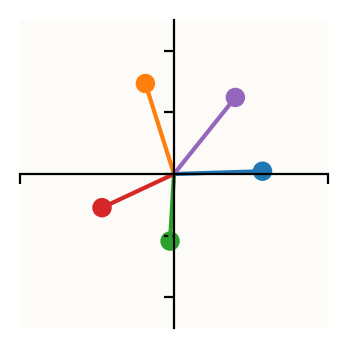

In [54]:
plot_intro_diagram(model)

In [57]:
def get_activation_from_word(word):
    tokens = dm.tokenize_data(word).to(DEVICE)
    outputs, hidden = model.forward(tokens.unsqueeze(0), return_hidden=True)
    _, predicted = torch.max(outputs.data, 1)
    return predicted, hidden

In [63]:
word = "unreliable"

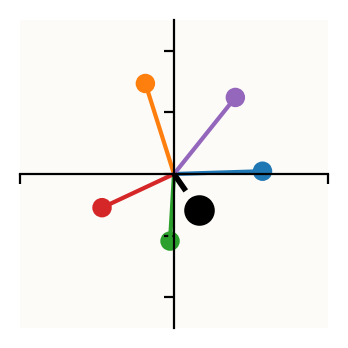

Predicted class: able


In [64]:
out, acts = get_activation_from_word(word)
plot_intro_diagram(model, acts)
print(f"Predicted class: {dm.str_classes[out]}")